### Matched-filtering: Finding well modelled signals in Gaussian noise  
Matched filtering can be shown to be the optimal method for "detecting" known signals in Gaussian noise.

In [1]:
%matplotlib inline
import numpy
import pylab

In [2]:
# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.

sample_rate = 1024 # samples per second
data_length = 1024 # seconds

In [3]:
# Generate a long stretch of white noise: the data series and the time series.

data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

In [4]:
# let's add a gravitational wave signal to some random part of this data

from pycbc.waveform import get_td_waveform

apx = 'IMRPhenomD'

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD (a phenomenological Inspiral–Merger–Ringdown wafeform model) 
# IMRPhenomD is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.

In [5]:
hp1, _ = get_td_waveform(approximant=apx, mass1=10, mass2=10, delta_t=1.0/sample_rate, f_lower=25)

In [6]:
# In this case we can interpret the cross-correlation of the signal with white noise as a signal-to-noise ratio.

hp1 = hp1 / max(numpy.correlate(hp1, hp1, mode='full'))**0.5

Text(0, 0.5, 'Normalized amplitude')

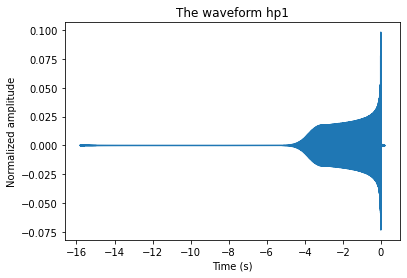

In [7]:
# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.

pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

Text(0, 0.5, 'Normalized amplitude')

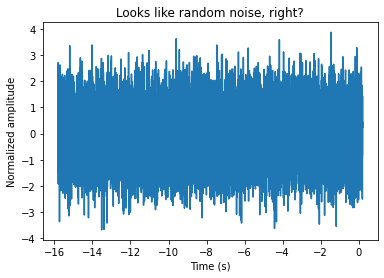

In [8]:
# Shift the waveform to start at a random time in the Gaussian noise data.

waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise, right?")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

Text(0, 0.5, 'Normalized amplitude')

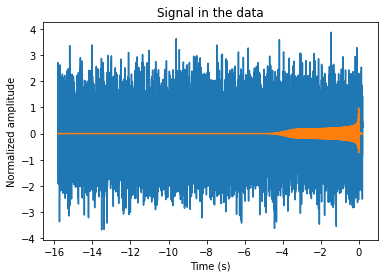

In [9]:
pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

In [10]:
# We will do the cross-correlation in the time domain, once for each time step. It runs slowly...

cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

Text(0, 0.5, 'Cross-correlation')

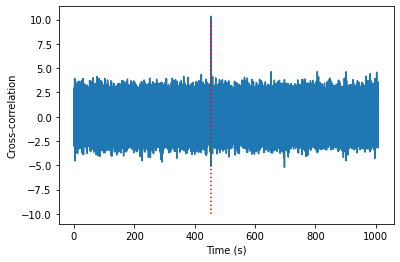

In [11]:
# plot the cross-correlated data vs time. Superimpose the location of the end of the signal;
# this is where we should find a peak in the cross-correlation.

pylab.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

### Detection in Colored Noise  
Here you can see that the largest spike from the cross-correlation comes at the time of the signal. We only really need one more ingredient to describe matched-filtering: "Colored" noise (Gaussian noise but with a frequency-dependent variance; white noise has frequency-independent variance).

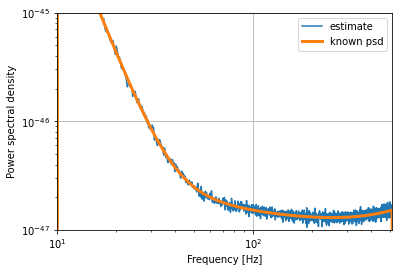

In [12]:
# Repeat the process, but generate a stretch of data colored with LIGO's zero-detuned--high-power noise curve.
# We'll use a PyCBC library to do this.

# http://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data 
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=flow, xmax=512)
pylab.ylim(1e-47, 1e-45)
pylab.xlabel('Frequency [Hz]')
pylab.ylabel('Power spectral density')
pylab.legend()
pylab.grid()
pylab.show()

# add the signal, this time, with a "typical" amplitude.
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

In [13]:
# Now we need to do is to "whiten" both the data, and the template waveform. 
# This can be done, in the frequency domain, by dividing by the PSD.

Text(0, 0.5, 'Cross-correlation')

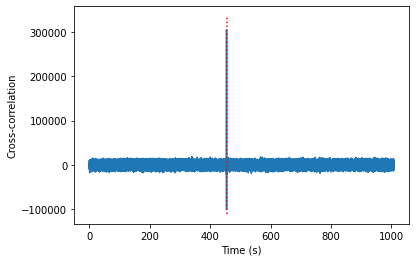

In [14]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries

# The PSD, sampled properly for the noisy data
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The PSD, sampled properly for the signal
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]

# Same, for the PSD sampled for the signal
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# convert both noisy data and the signal to frequency domain,
# and divide each by ASD=PSD**0.5, then convert back to time domain.
# This "whitens" the data and the signal template. 
# Multiplying the signal template by 1E-21 puts it into realistic units of strain.
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21

# Now let's re-do the correlation, in the time domain, but with whitened data and template.
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()
    
# plot the cross-correlation in the time domain. Superimpose the location of the end of the signal.
# Note how much bigger the cross-correlation peak is, relative to the noise level,
# compared with the unwhitened version of the same quantity. SNR is much higher!
pylab.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

### Question 1  
Histogram the whitened time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the standard deviation? (We have not been careful in normalizing the whitened data properly).

data_whitened.data.std = 22.476468072030492


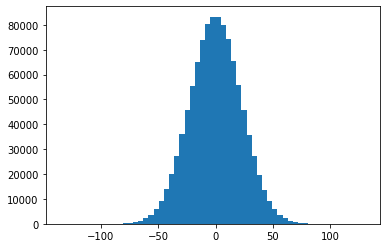

In [15]:
datastd = data_whitened.data.std()
pylab.hist(data_whitened.data, bins=numpy.arange(-6,6,0.2)*datastd)
print('data_whitened.data.std =',datastd)

### Question 2  
Histogram the above cross-correlation time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the standard deviation?

cross_correlation.std = 3987.62515727425


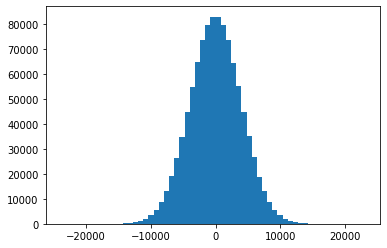

In [16]:
ccstd = cross_correlation.std()
pylab.hist(cross_correlation, bins=numpy.arange(-6,6,0.2)*ccstd)
print('cross_correlation.std =',ccstd)

### Question 3  
Find the location of the peak. (Note that here, it can be positive or negative), and the value of the SNR of the signal (which is the absolute value of the peak value, divided by the standard deviation of the cross-correlation time series).

In [17]:
# locate the peak of the cross-correlation time-series, compute the SNR there
ipeak = numpy.argmax(numpy.abs(cross_correlation))
tpeak = times[ipeak]
apeak = cross_correlation[ipeak]
mpeak = numpy.max(numpy.abs(cross_correlation))
dstd = cross_correlation.std()
snr = apeak/dstd
print('snr = ', snr)

snr =  76.40485809745924
